# Binomial "toy model"

To better think about the evaluation techniques, we look at a "toy model" where there are exactly 2 grid cells, say H and T.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import scipy.stats as stats
import scipy.integrate
import open_cp.evaluation

# Scoring

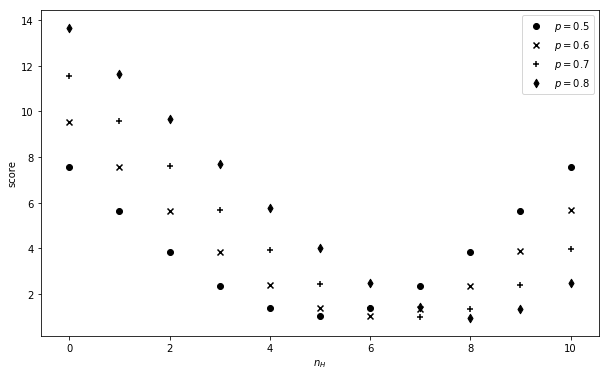

In [2]:
N = 10

fig, ax = plt.subplots(figsize=(10,6))

for p, ma in zip([0.5, 0.6, 0.7, 0.8], ["o", "x", "+", "d"]):
    x = list(range(0,11))
    y = [open_cp.evaluation.poisson_crps(p*N, nH) + open_cp.evaluation.poisson_crps(N-p*N, N-nH)
        for nH in x ]
    ax.scatter(x, y, marker=ma, color="black", label="$p={}$".format(p))
    ax.legend()
    ax.set(xlabel="$n_H$", ylabel="score")
    None

In [3]:
fig.savefig("crps.pdf")

# Bayesian stuff

Here we think about using Bayesian modelling for this problem.  In general we are using a Dirichlet prior, but when we have only two grid cells, this reduces to a beta distribution.

We start by visualising the prior and posterior.

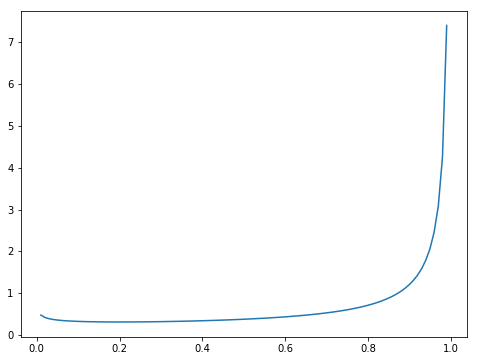

In [4]:
t = 1
p = 0.8
prior = stats.beta(t*p, t*(1-p))

fig, ax = plt.subplots(figsize=(8,6))
x = np.linspace(0,1,100)
ax.plot(x, prior.pdf(x))
None

In [5]:
# Could sample directly from a Poisson of course...
def trial(real_p = 0.8, size = 10):
    return (np.random.random(size) > real_p).astype(np.float)

trial()

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [6]:
def posterior(t, p, data):
    n = len(data)
    n1 = sum(data == 0)
    n2 = sum(data == 1)
    assert n1 + n2 == n
    return stats.beta(t*p+n1, t*(1-p)+n2)

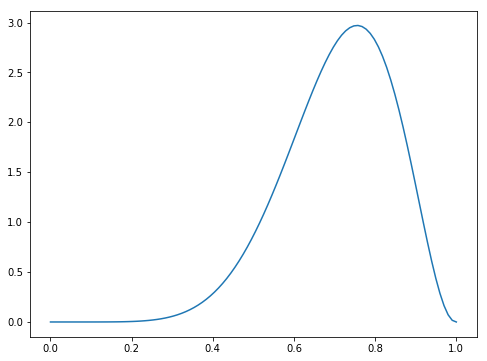

In [7]:
post = posterior(t,p,trial())

fig, ax = plt.subplots(figsize=(8,6))
x = np.linspace(0,1,100)
ax.plot(x, post.pdf(x))
None

Now we visualise the "Kullback-Leibler function" which is real-valued function we integrate to get the Kullback-Leibler divergance.

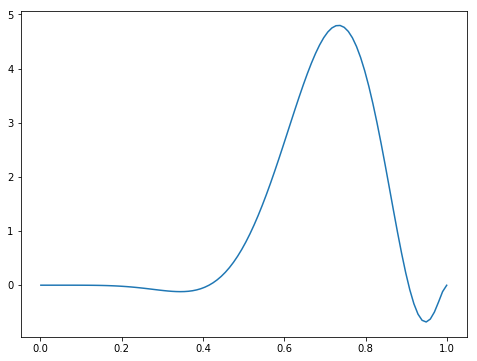

In [8]:
def kl(prior, post):
    def func(x):
        return post.pdf(x) * (np.log(post.pdf(x)) - np.log(prior.pdf(x)))
    return func

fig, ax = plt.subplots(figsize=(8,6))
d=1e-3
x = np.linspace(d,1-d,100)
ax.plot(x, kl(prior,post)(x))
None

In [9]:
scipy.integrate.quad(kl(prior, post), 0, 1)

(1.169978141251569, 1.055165248071315e-09)

# Some plots

Fixed data, random sample from $\operatorname{Bin}(0.8, 20)$

Top row shows the prior (blue) and posterior (orange).  Bottom row shows the density $P\log(P/Q)$ which we integrate to find the KL divergence.

What I _think_ this shows is the sensitivity to $t$.  For $t$ very small, we have a very flat prior, and so the posterior moves a lot.  When $t$ is very large, we have a lot of "certainty" in our prediction, and so the data makes little difference, and the divergence is small.

In the 2nd plot below we show, given that the data really comes from $\operatorname{Bin}(0.8, 20)$, the cumulative density functions of $D_{KL}$.

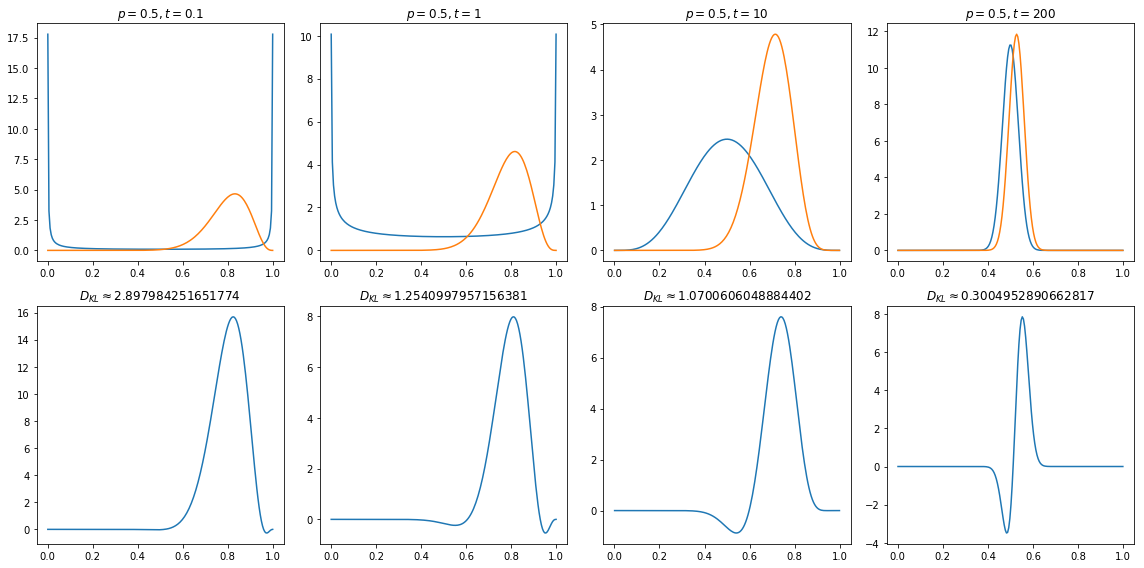

In [10]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16,8))

data = trial(size=20)
for ax, (p,t) in zip(axes.T, [(0.5,0.1), (0.5,1), (0.5,10), (0.5,200)]):
    prior = stats.beta(t*p, t*(1-p))
    post = posterior(t,p,data)
    steps = 200
    x = np.linspace(0.001, 1-0.001, steps)
    ax[0].plot(x, prior.pdf(x))
    ax[0].plot(x, post.pdf(x))
    ax[0].set_title("$p={}, t={}$".format(p, t))
    y = kl(prior, post)(x)
    ax[1].plot(x, y)
    ax[1].set_title("$D_{{KL}}\\approx {}$".format(np.sum(y)/steps))
fig.tight_layout()

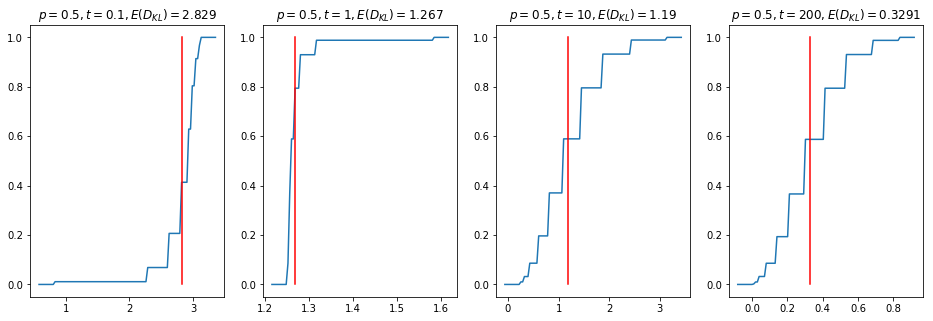

In [11]:
fig, axes = plt.subplots(ncols=4, figsize=(16,5))

for ax, (p,t) in zip(axes.T, [(0.5,0.1), (0.5,1), (0.5,10), (0.5,200)]):
    size = 20
    binom = stats.binom(size, 0.8)
    out = []
    for n1 in range(size+1):
        prior = stats.beta(t*p, t*(1-p))
        n2 = size - n1
        post = stats.beta(t*p+n1, t*(1-p)+n2)
        d, _ = scipy.integrate.quad(kl(prior, post), 0, 1)
        out.append(d)
    out = np.asarray(out)

    # Estimate the CDF
    sample_size = 100000
    data = out[binom.rvs(sample_size)]
    x1, x2 = np.min(out), np.max(out)
    xd = (x2 - x1) / 10
    x = np.linspace(x1 - xd, x2 + xd, 100)
    y = np.sum(data[:,None] <= x[None,:], axis=0) / sample_size
    ax.plot(x, y)
    x = np.mean(data)
    ax.plot([x,x],[0,1], color="red")
    ax.set_title("$p={}, t={}, E(D_{{KL}})={:.4}$".format(p, t, x))

## Compare to open_cp code

Seem to get the same answer (good!)

In [12]:
import open_cp.data
import open_cp.predictors
import open_cp.evaluation
import datetime

In [13]:
prediction = open_cp.predictors.GridPredictionArray(10, 10, np.asarray([[0.5, 0.5]]))
data = trial(0.8, 20)
xcs = data * 10 + 5
ycs = [5] * len(xcs)
times = [datetime.datetime(2017,4,5) + datetime.timedelta(hours=i) for i in range(len(xcs))]
tps = open_cp.data.TimedPoints.from_coords(times, xcs, ycs)

In [14]:
hatp = open_cp.evaluation.bayesian_dirichlet_prior(prediction, tps, bias=1)

In [15]:
p, t = 0.5, 1
prior = stats.beta(p*t, (1-p)*t)
n1, n2 = np.sum(data==0), np.sum(data==1)
post = stats.beta(p*t+n1, (1-p)*t+n2)
x = scipy.integrate.quad(kl(prior, post), 0, 1)[0]
x, hatp, x - hatp

(1.2643242732937332, 1.2643242732888424, 4.8907544680787396e-12)

# Scoring results

We perform the following experiment:
- Pick a sample size, from Poisson(10)
- Pick that many values from a binomial, with `real_p` mean
- Score this using $p=0.5$ and $p=0.8$

In [16]:
def score(t, p, data):
    prior = stats.beta(t*p, t*(1-p))
    post = posterior(t, p, data)
    x, _ = scipy.integrate.quad(kl(prior, post), 0, 1)
    return x

def plot(out):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(*out.T)
    ax.set(xlabel="p=0.5", ylabel="p=0.8")
    xmin, xmax = min(out[:,0]), max(out[:,0])
    x1 = xmin - (xmax-xmax)/5
    x2 = xmax + (xmax-xmax)/5
    ax.plot([x1,x2], [x1,x2], color="red", linewidth=1)
    print("Count:", sum(x1 <= x2 for x1,x2 in out))
    
def simulate(real_p, average_size=10, trials=100, t=1):
    out = []
    for _ in range(trials):
        data = trial(real_p, size=np.random.poisson(average_size))
        x1 = score(t, 0.5, data)
        x2 = score(t, 0.8, data)
        out.append((x1,x2))
    out = np.asarray(out)
    return out

Count: 89


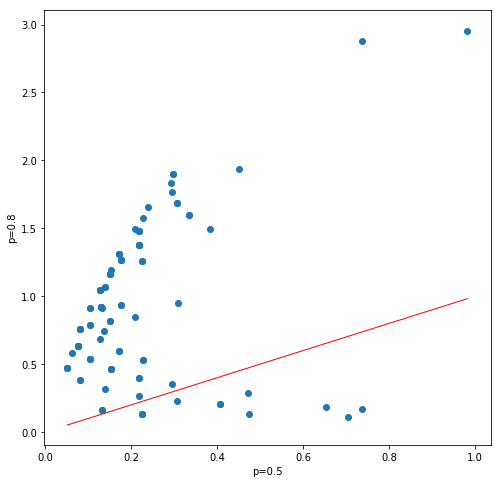

In [17]:
plot( simulate(0.5, t=10) )

Count: 22


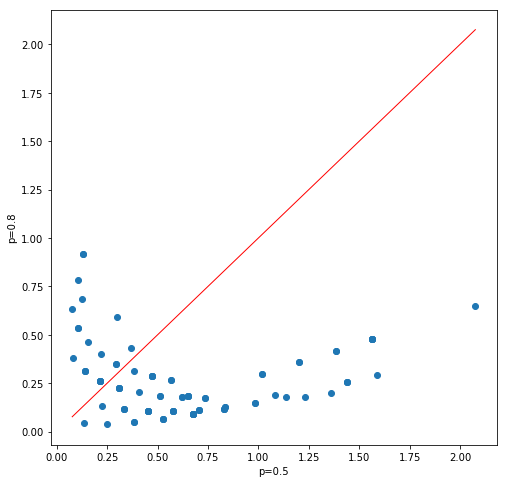

In [18]:
plot( simulate(0.8, t=10) )

Count: 54


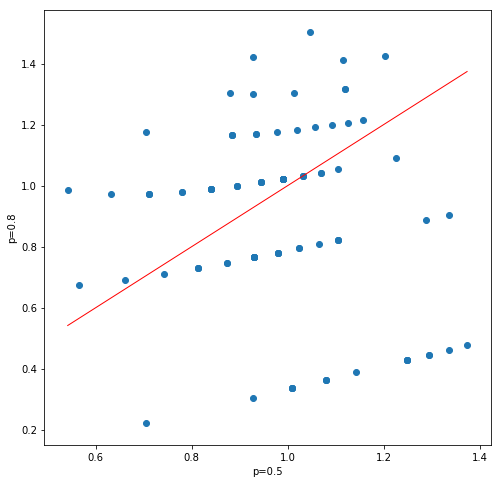

In [21]:
# Performs much less well
plot( simulate(0.8, t=1) )